### Create Conda environment
run below commands in terminal but make sure conda is installed or use anaconda prompt which you will get as part of anaconda installation
conda create -n envname python=3.9 ipykernel it will create a conda env named envname and install python version 3.9 and a ipykernel inside this environment

- Activate the environment conda activate envname

- add newly created environment to the notebook as kernel python -m ipykernel install --user --name=envname

- install notebook inside the environment pip install notebook

- Now install all required dependencies to run this notebook

- pip install pandas
- pip install numpy
- pip install scikit-learn
- pip install imblearn
- pip install matplotlib
- pip install mlflow

- Now open the notebook using below command: (from the anaconda prompt inside conda environment)

jupyter notebook

In [11]:
import pandas as pd

In [12]:
import sys
print(sys.executable)

c:\Users\ayush\anaconda3\envs\exper_tracking\python.exe


In [13]:
import pandas as pd
import numpy as np

In [14]:
def load_data(path):
    data=pd.read_csv(path)
    return data

In [15]:
data=load_data('https://raw.githubusercontent.com/TripathiAshutosh/mlflow/main/banking.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [29]:
def data_cleaning(data):
    print("Na values are avialable in data ")
    print(data.isna().sum())
    print("after dropping na values")
    print(data.isna().sum())
    return data

In [17]:
def preprocessing(data):
    data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])
    
    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1=data.join(cat_list)
        data=data1

    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    data_vars=data.columns.values.tolist()
    to_keep=[i for i in data_vars if i not in cat_vars]
    
    final_data=data[to_keep]
    
    
    final_data.columns = final_data.columns.str.replace('.','_')
    final_data.columns = final_data.columns.str.replace(' ','_')
    return final_data

In [35]:
from sklearn.model_selection import train_test_split

def train_test_split(final_data):
    from sklearn.model_selection import train_test_split
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=47)
    return X_train, X_test, y_train, y_test

In [38]:
def over_sampling_target_class(X_train,y_train):
    ## over smapling using smote
    from imblearn.over_sampling import SMOTE

    os=SMOTE()
    columns=X_train.columns
    os_data_x,os_data_y=os.fit_resample(X_train,y_train)
    os_data_x=pd.DataFrame(data=os_data_x,columns=columns)
    os_data_y=pd.DataFrame(data=os_data_y,columns=['y'])
    ## we can check the number of our data
    print("length of oversampled data is ",len(os_data_x))
    print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
    print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
    print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_x))
    print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_x))
    
    X_train = os_data_x
    y_train = os_data_y['y']
 
    return X_train, y_train



In [20]:
def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

In [21]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [22]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [23]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [58]:
def create_confusion_matrix_plot(clf, X_test, y_test):
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
    cm=confusion_matrix(y_test, predict_on_test_data(clf,X_test), labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot()
    plt.savefig('confusion_matrix.png')

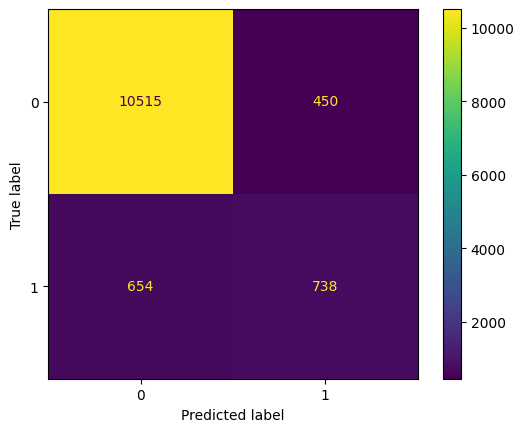

In [59]:

create_confusion_matrix_plot(model, X_test, y_test)

In [26]:
def hyper_parameter_tuning(X_train, y_train):
    # define random parameters grid
    n_estimators = [5,21,51,101] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                  }
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')
    # print the best parameters
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, max_features = max_features,
                                         max_depth= max_depth, bootstrap=bootstrap) 
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

In [27]:
data=load_data('https://raw.githubusercontent.com/TripathiAshutosh/mlflow/main/banking.csv')

In [30]:
cleaned_data=data_cleaning(data)

Na values are avialable in data 
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
after dropping na values
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [31]:
final_data=preprocessing(cleaned_data)

In [36]:
X_train,X_test,y_train,y_test=train_test_split(final_data)

In [39]:
X_train, y_train = over_sampling_target_class(X_train, y_train)

length of oversampled data is  51166
Number of no subscription in oversampled data 25583
Number of subscription 25583
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [40]:
model = training_basic_classifier(X_train,y_train)

In [41]:
y_pred = predict_on_test_data(model,X_test)

In [42]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [43]:
y_pred_prob = predict_prob_on_test_data(model,X_test) #model.predict_proba(X_test)

In [44]:
y_pred_prob

array([[0.99009901, 0.00990099],
       [0.98019802, 0.01980198],
       [0.92079208, 0.07920792],
       ...,
       [1.        , 0.        ],
       [0.72277228, 0.27722772],
       [0.98019802, 0.01980198]])

In [45]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

In [46]:
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.53, 'entropy': 0.2}


In [52]:
create_roc_auc_plot(model, X_test, y_test)

AttributeError: module 'sklearn.metrics' has no attribute 'plot_roc_curve'

In [51]:

create_confusion_matrix_plot(model, X_test, y_test)

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (c:\Users\ayush\anaconda3\envs\exper_tracking\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

####  MLFLOW work starts from here

In [61]:
experiment_name="basic_classifier"
run_name='term_deposit'
run_metrics=get_metrics(y_test,y_pred,y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.53, 'entropy': 0.2}


In [65]:
create_experiment(experiment_name,run_name,run_metrics,model,'confusion_matrix.png')

2024/04/13 11:20:07 INFO mlflow.tracking.fluent: Experiment with name 'basic_classifier' does not exist. Creating a new experiment.


Run - term_deposit is logged to Experiment - basic_classifier


In [78]:
def create_experiment(experiment_name,run_name,run_metrics,model,confusion_metric_path=None,run_params=None):
    import mlflow
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run():
        if not run_params==None:
            for param in run_params:
                mlflow.log_param(param,run_params[param])
        for metric in run_metrics:
            mlflow.log_metric(metric,run_metrics[metric])

        mlflow.sklearn.log_model(model,'model')
        if not confusion_metric_path==None:
            mlflow.log_artifact(confusion_metric_path,'confusion_matrix')
        
        mlflow.set_tag('tag1',"Random Forest")
        mlflow.set_tags({"tag2":'Randomized search Cv',"tag3":"production"})
        
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))


In [71]:
import mlflow
experiment_name='optimized_model'
run_name='Random_search_cv_tuned_model'
model_tuned,best_params=hyper_parameter_tuning(X_train,y_train)
run_params=best_params
y_pred=predict_on_test_data(model_tuned,X_test)
y_pred_prob=predict_prob_on_test_data(model_tuned,X_test)
run_metrics=get_metrics(y_test,y_pred,y_pred_prob)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\ayush\anaconda3\envs\exper_tracking\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
235 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
67 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ayush\anaconda3\envs\exper_tracking\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ayush\anaconda3\envs\exper_tracking\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\ayush\anaconda3\envs\exper_tracking\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    v

Random grid:  {'n_estimators': [5, 21, 51, 101], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 101, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 120, 'bootstrap': True}  



In [79]:
for param in run_params:
    print(param,run_params[param])

n_estimators 101
min_samples_split 6
min_samples_leaf 1
max_features sqrt
max_depth 120
bootstrap True


In [80]:
run_metrics

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.56, 'entropy': 0.19}

In [81]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned,'confusion_matrix.png',run_params)

2024/04/13 12:05:05 INFO mlflow.tracking.fluent: Experiment with name 'optimized_model' does not exist. Creating a new experiment.


Run - Random_search_cv_tuned_model is logged to Experiment - optimized_model
